In [70]:
from pathlib import Path
import utils
from typing import Callable
import scipy
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

from tsfel.feature_extraction import features
from sklearn.utils import resample

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [71]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx

def calc_statistics(s):
    maxim = np.max(s, axis = 1)[:, np.newaxis]
    minim = np.min(s, axis = 1)[:, np.newaxis]
    mean = np.mean(s, axis = 1)[:, np.newaxis]
    
    mode = scipy.stats.mode(s, axis = 1)[0]
    
    return np.concatenate([maxim, minim, mean, mode], axis = 1)

def generate_df(data,features, chanels): 
    #le paso la data resultante de la extraccion de features, los nombres de los features en una lista y de 
    #los canales
    features_name=[]
    for ch in chanels:
        for feature in features:
            features_name.append(feature + 'ch ' + str (ch))
    return pd.DataFrame(data, columns=features_name)

In [72]:
def fft_neighbours(signal):
    N = signal.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    frq = np.fft.rfftfreq(N, dt)
    tf = abs(np.fft.rfft(sig_filt, axis = 1))
    
    #Interest Frequencies:
    interest_frq = [12.5, 16.5]
    harmonics = True
    bandwidth = 1.0
    
    mask = []
    selected_frq = []
    
    for f in frq:
        if any([int_f - bandwidth < f < int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        elif harmonics and any([2*int_f - bandwidth < f < 2*int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        else:
            mask.append(False)
        
    #print(selected_frq)
    
    return tf[:, mask]

In [73]:
def calc_max_filtered(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 9
    f_high = 22
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    maximum = np.argmax(Sxx, axis=1)
  
    item=freqs[maximum]
    return item.reshape((signal_matrix.shape[0], 1))

In [74]:
def filtered_range(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 9
    f_high = 40 #35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    index_low=np.where(freqs>=10)[0][0]

    #index_high=np.where(freqs>=35)[0][0]
    index_high=np.where(freqs>=40)[0][0]

    
    return Sxx[:,index_low:index_high]

In [75]:
def filtered_pca(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    index_low=np.where(freqs>=10)[0][0]

    index_high=np.where(freqs>=35)[0][0]    
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    pca.fit(Sxx[:,index_low:index_high])
    proyected_features_freq = pca.transform(Sxx[:,index_low:index_high])
    
    return proyected_features_freq.reshape((signal_matrix.shape[0], 3))

In [76]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, \
        self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp == self.ws
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata


Para levantar los datasets desde txt o csv:
- Este notebook, o el notebook que usen que tenga la clase arriba definida, tiene que estar en el mismo directorio que el archivo utils.py, que tiene algunas funciones usadas en los métodos de la clase.
- Descarguen el .zip de la base de datos de nuevo y extraiganlos a un directorio llamado <path al repo en su máquina>/MentoriaBCI/Database/
- Definan el csvs_path acorde al directorio anterior:
    - csvs_path = '<PATH AL REPO>/MetoriaBCI/Database' ej: '/home/joaquin/Desktop/MentoriaDiploDatos/MetoriaBCI/Database'

# Recorrido por el código BCIDataset

Generamos diferentes datasets en base a las funciones de extracción de features del punto anterior.

In [77]:
# csvs_path = '/home/ariel/gabriel/diplo_de_datos/mentoria_BCI/tp3'
csvs_path = '../../data'


In [78]:
# dataset con los valores de frecuencia donde aparece la amplitud máxima
dataset_filtered_max = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=calc_max_filtered)

df_max_freq=generate_df(dataset_filtered_max.complete_examples_features,['max freq '], [0,1,2,3])
df_max_freq['max_freq_mean'] = df_max_freq.mean(axis=1)
df_max_freq['max_freq_mode'] = scipy.stats.mode(df_max_freq,axis=1)[0]
df_max_freq['max_freq_median']=np.median(df_max_freq,axis=1)
df_max_freq['max_freq_quantile']=np.quantile(df_max_freq,0.9,axis=1)
df_max_freq['max_freq_std']=np.std(df_max_freq,axis=1)
df_max_freq['max_freq_var']=np.var(df_max_freq,axis=1)
df_max_freq['max_freq_entropy'] = scipy.stats.entropy(df_max_freq,axis=1)
df_max_freq['max_freq_skew'] = scipy.stats.skew(df_max_freq,axis=1)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


In [79]:
labels = pd.DataFrame(dataset_filtered_max.complete_labels,columns=['labels'])
metadata_all = pd.DataFrame(dataset_filtered_max.complete_metadata, columns = ['purness', 't_start', 't_end', 
                                                                      'subject', 'session'])
max_freq_with_labels = df_max_freq.merge(labels,left_index=True,right_index=True)
max_freq_with_labels.head()

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,max_freq_mean,max_freq_mode,max_freq_median,max_freq_quantile,max_freq_std,max_freq_var,max_freq_entropy,max_freq_skew,labels
0,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,0.000000,13.597147,2.196067,-1.630989,99.0
1,10.666667,10.666667,11.200000,12.533333,11.266667,10.666667,10.933333,11.773333,0.615828,11.429167,2.219547,-1.604312,99.0
2,10.666667,10.400000,10.400000,12.533333,11.000000,10.400000,10.533333,11.613333,0.716806,10.785793,2.222344,-1.566522,99.0
3,13.066667,11.466667,13.600000,18.400000,14.133333,11.466667,13.333333,15.840000,2.151000,17.777155,2.231747,-0.981291,99.0
4,12.266667,9.866667,16.800000,12.266667,12.800000,12.266667,12.266667,14.400000,1.879716,15.063020,2.233222,-1.111619,99.0


In [80]:
# dataset con la senal filtrada y aplicando pca
dataset_filtered_pca = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_pca)
df_pca_freq=generate_df(dataset_filtered_pca.complete_examples_features,['pca 0 ', 'pca 1 ','pca 2 '], [0,1,2,3])
pca_with_labels = df_pca_freq.merge(labels,left_index=True,right_index=True)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


In [81]:
# dataset con la senal filtrada y sólo teniendo el rango de frecuencias de interés
dataset_filtered_range = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_range)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


Ahora realizamos una busqueda de features sobre la transformada de fourier de la senal. La senal la filtramos entre 10 y 35 Hz, y luego sacamos estadisticos (media, mediana, suma, suma ponderada por frecuencia, quantil 90, desvio estandar, varianza, entropia, skew y kurtosis) dentro de las frecuencias de interes ya sea para la etiqueta 1 en 12,5 Hz o para la etiqueta 2 16,5 hz. Usamos estadisticos alrededor de esa frecuencia en +- 1 Hz. A su vez dejamos los valores de amplitud de la senal dentro del rango de interes y de sus armonicos (25 y 33 Hz).

In [82]:
N=dataset_filtered_range.complete_examples_signal.shape[1]
dt = 1/200
freqs_all = np.fft.rfftfreq(n=int(N/4), d=dt)
index_low=np.where(freqs_all>=10)[0][0]
#index_high=np.where(freqs_all>=35)[0][0]
index_high=np.where(freqs_all>=40)[0][0]

name= [str(i) for i in list(freqs_all[index_low:index_high].round(2))]
df_range_freq=pd.DataFrame(dataset_filtered_range.complete_examples_features,columns=name+name+name+name)

df_range_freq['freq_label_1_skew']=scipy.stats.skew(df_range_freq[['12.0','12.27','12.53','12.8','13.07']],axis=1)
df_range_freq['freq_label_2_skew']=scipy.stats.skew(df_range_freq[[ '16.0','16.27', '16.53', '16.8','17.07']],axis=1)

df_range_freq['freq_label_1_kurtosis']=scipy.stats.kurtosis(df_range_freq[['12.0','12.27','12.53','12.8','13.07']],axis=1)
df_range_freq['freq_label_2_kurtosis']=scipy.stats.kurtosis(df_range_freq[[ '16.0','16.27', '16.53', '16.8','17.07']],axis=1)


#features sin log

array_freqs_label_1=df_range_freq[['12.0','12.27','12.53','12.8','13.07']].to_numpy()
array_freqs_label_2=df_range_freq[['16.0','16.27', '16.53', '16.8','17.07']].to_numpy()

#Hago una suma ponderada de los 4 canales en cjto. tener en cuenta que primero aparecen los valores 
#de cada frecuencia repetida por los cuatro canales

sum_weighted_1=np.dot(array_freqs_label_1,[0.1/4,0.1/4,0.1/4,0.1/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.4/4,0.4/4,0.4/4,0.4/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.1/4,0.1/4,0.1/4,0.1/4])

sum_weighted_2=np.dot(array_freqs_label_2,[0.1/4,0.1/4,0.1/4,0.1/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.4/4,0.4/4,0.4/4,0.4/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.1/4,0.1/4,0.1/4,0.1/4])

df_range_freq['sum_weighted_label_1']= sum_weighted_1.tolist()
df_range_freq['sum_weighted_label_2']= sum_weighted_2.tolist()

In [83]:
N=dataset_filtered_range.complete_examples_signal.shape[1]
dt = 1/200
freqs_all = np.fft.rfftfreq(n=int(N/4), d=dt)
index_low=np.where(freqs_all>=10)[0][0]
#index_high=np.where(freqs_all>=35)[0][0]
index_high=np.where(freqs_all>=40)[0][0]

name= [str(i) for i in list(freqs_all[index_low:index_high].round(2))]
df_range_freq=pd.DataFrame(dataset_filtered_range.complete_examples_features,columns=name+name+name+name)

df_range_freq['freq_label_1_mean']=np.log(df_range_freq[['12.27','12.53','12.8']].mean(axis=1))
df_range_freq['freq_label_2_mean']=np.log(df_range_freq[[ '16.27', '16.53', '16.8']].mean(axis=1))

df_range_freq['freq_label_1_median']=np.log(np.median(df_range_freq[['12.27','12.53','12.8']],axis=1))
df_range_freq['freq_label_2_median']=np.log(np.median(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1))

df_range_freq['freq_label_1_sum'] = np.log(df_range_freq[['12.27','12.53','12.8']].sum(axis=1)/4)
df_range_freq['freq_label_2_sum'] = np.log(df_range_freq[[ '16.27', '16.53', '16.8']].sum(axis=1)/4)

df_range_freq['freq_label_1_quantile']=np.log(np.quantile(df_range_freq[['12.27','12.53','12.8']],0.9,axis=1))
df_range_freq['freq_label_2_quantile']=np.log(np.quantile(df_range_freq[[ '16.27', '16.53', '16.8']],0.9,axis=1))

df_range_freq['freq_label_1_std']=np.log(np.std(df_range_freq[['12.27','12.53','12.8']],axis=1))
df_range_freq['freq_label_2_std']=np.log(np.std(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1))

df_range_freq['freq_label_1_var']=np.log(np.var(df_range_freq[['12.27','12.53','12.8']],axis=1))
df_range_freq['freq_label_2_var']=np.log(np.var(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1))


df_range_freq['freq_label_1_entropy']=np.log(scipy.stats.entropy(df_range_freq[['12.27','12.53','12.8']],axis=1))
df_range_freq['freq_label_2_entropy']=np.log(scipy.stats.entropy(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1)
                                            
                                            )
df_range_freq['freq_label_1_skew']=scipy.stats.skew(df_range_freq[['12.27','12.53','12.8']],axis=1)
df_range_freq['freq_label_2_skew']=scipy.stats.skew(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1)
df_range_freq['freq_label_1_kurtosis']=scipy.stats.kurtosis(df_range_freq[['12.27','12.53','12.8']],axis=1)
df_range_freq['freq_label_2_kurtosis']=scipy.stats.kurtosis(df_range_freq[[ '16.27', '16.53', '16.8']],axis=1)

array_freqs_label_1=df_range_freq[['12.27','12.53','12.8']].to_numpy()
array_freqs_label_2=df_range_freq[['16.27', '16.53', '16.8']].to_numpy()

#Hago una suma ponderada de los 4 canales en cjto. tener en cuenta que primero aparecen los valores 
#de cada frecuencia repetida por los cuatro canales
sum_weighted_1_log=np.log(np.dot(array_freqs_label_1,[
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.6/4,0.6/4,0.6/4,0.6/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                ]))

sum_weighted_2_log=np.log(np.dot(array_freqs_label_2,[
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 0.6/4,0.6/4,0.6/4,0.6/4,
                                 0.2/4,0.2/4,0.2/4,0.2/4,
                                 ]))


df_range_freq['sum_weighted_label_1']= sum_weighted_1_log.tolist()
df_range_freq['sum_weighted_label_2']= sum_weighted_2_log.tolist()

In [84]:
freq_range_with_labels = df_range_freq.merge(labels,left_index=True,right_index=True)

In [85]:
# IMPORTANTE: Eliminar features que tengan alta correlación entre sí, 
# ya que suele mejorar las métricas de los modelos

# concatenamos los dfs

best_features=df_max_freq.merge(df_range_freq[['freq_label_1_mean','freq_label_2_mean','freq_label_1_sum','freq_label_2_sum',
          'freq_label_1_median','freq_label_2_median','freq_label_1_quantile','freq_label_2_quantile'
                                 ,'sum_weighted_label_1','sum_weighted_label_2','freq_label_1_std',
                                 'freq_label_2_std','freq_label_1_var','freq_label_2_var','freq_label_1_entropy',
                                 'freq_label_2_entropy','freq_label_1_skew','freq_label_2_skew','freq_label_1_kurtosis',
                                 'freq_label_2_kurtosis','12.27','12.53','12.8','16.27', '16.53', '16.8'
                                               ,'24.8', '25.07', '25.33','32.8','33.07', '33.33'
                                ]],left_index=True,right_index=True)
best_features["purness"]=metadata_all["purness"].replace({'True':1,'False':0})
best_features = best_features.merge(labels,left_index=True,right_index=True)

print(best_features.shape)
best_features.head()

(2614, 82)


,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,max_freq_mean,max_freq_mode,max_freq_median,max_freq_quantile,max_freq_std,max_freq_var,...,33.07,33.07,33.07,33.07,33.33,33.33,33.33,33.33,purness,labels
0,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,11.733333,0.000000,13.597147,...,3.737959,3.583438,5.296199,0.488755,1.840190,1.565958,2.268546,0.003789,1,99.0
1,10.666667,10.666667,11.200000,12.533333,11.266667,10.666667,10.933333,11.773333,0.615828,11.429167,...,4.798009,4.311819,6.379313,0.355643,0.999170,0.866651,1.118516,0.157813,1,99.0
2,10.666667,10.400000,10.400000,12.533333,11.000000,10.400000,10.533333,11.613333,0.716806,10.785793,...,3.725539,3.897317,4.568142,0.345031,1.849562,2.321612,2.580273,0.310619,1,99.0
3,13.066667,11.466667,13.600000,18.400000,14.133333,11.466667,13.333333,15.840000,2.151000,17.777155,...,0.200017,0.714550,0.596090,0.108508,0.029691,0.028834,0.027047,0.065873,1,99.0
4,12.266667,9.866667,16.800000,12.266667,12.800000,12.266667,12.266667,14.400000,1.879716,15.063020,...,0.271507,0.200992,0.337256,0.324981,0.145418,0.298858,0.152423,0.098031,1,99.0


### Manejo de desbalanceo de clase - Downsample

In [86]:
# Display new class counts
best_features.labels.value_counts()

99.0    1609
2.0      524
1.0      481
Name: labels, dtype: int64

In [87]:
# Separate classes
df_class1 = best_features[best_features.labels==1]
df_class2 = best_features[best_features.labels==2]
df_class99 = best_features[best_features.labels==99]
 
# Downsample majority class
df_class99_downsampled = resample(df_class99, 
                                 replace=False,    # sample without replacement
                                 n_samples=1000,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
best_features = pd.concat([df_class1, df_class2, df_class99_downsampled])
 
# Display new class counts
best_features.labels.value_counts()

99.0    1000
2.0      524
1.0      481
Name: labels, dtype: int64

### Correlations Matrix

<AxesSubplot:>

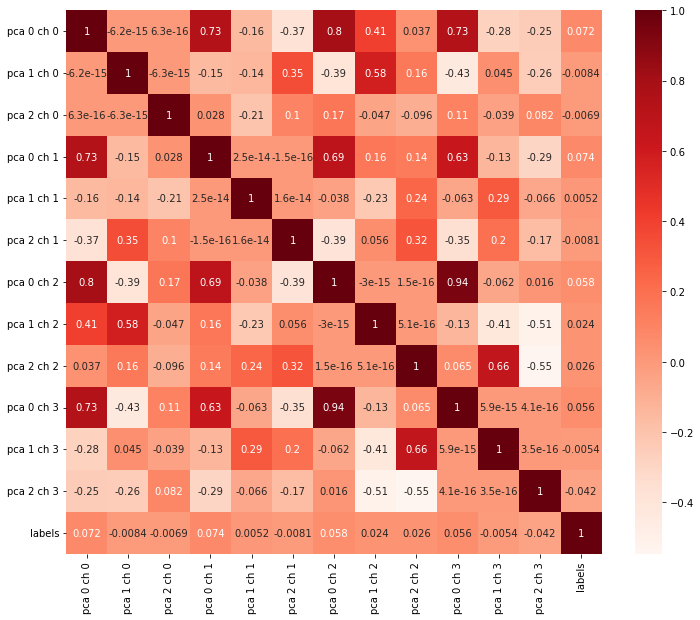

In [88]:
# pca_with_labels
corr_table = pca_with_labels.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds)

<AxesSubplot:>

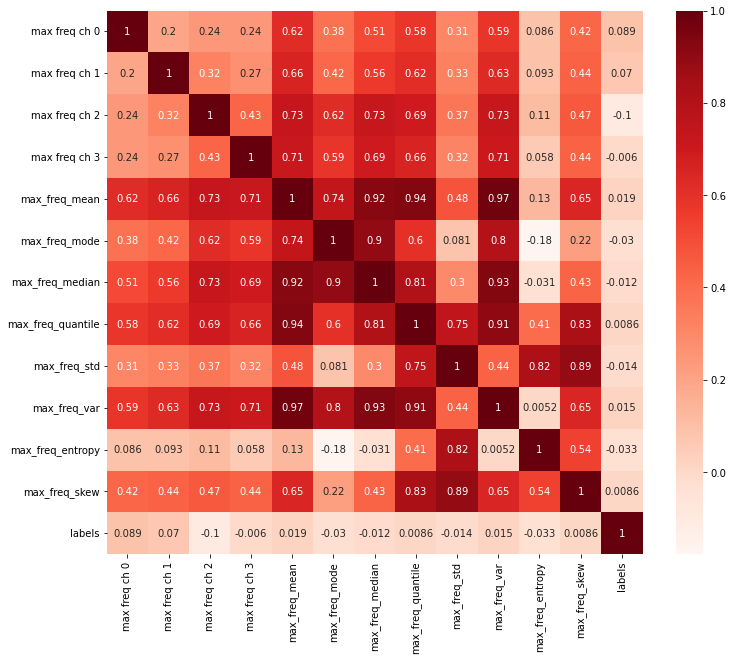

In [89]:
# max_freq_with_labels
corr_table = max_freq_with_labels.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds)

In [90]:
freq_range_with_labels.shape

(2614, 469)

<AxesSubplot:>

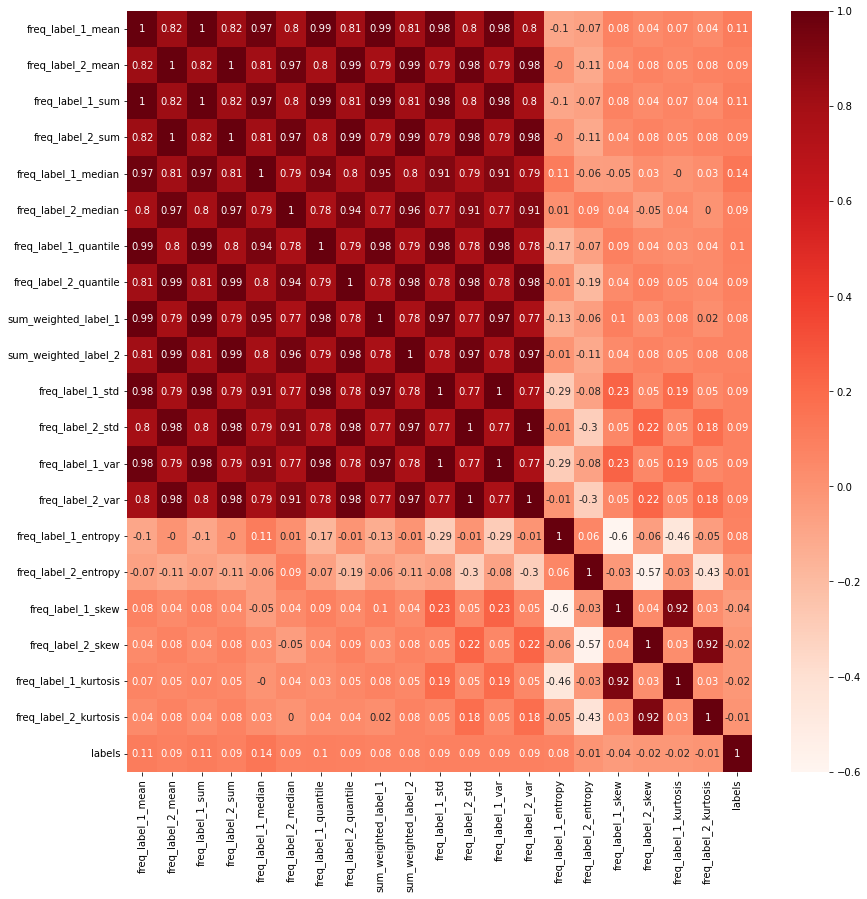

In [91]:
# freq_range_with_labels - Parte 1
corr_table = freq_range_with_labels[['freq_label_1_mean','freq_label_2_mean','freq_label_1_sum','freq_label_2_sum',
          'freq_label_1_median','freq_label_2_median','freq_label_1_quantile','freq_label_2_quantile'
                                 ,'sum_weighted_label_1','sum_weighted_label_2','freq_label_1_std',
                                 'freq_label_2_std','freq_label_1_var','freq_label_2_var','freq_label_1_entropy',
                                 'freq_label_2_entropy','freq_label_1_skew','freq_label_2_skew','freq_label_1_kurtosis',
                                 'freq_label_2_kurtosis', 'labels'
                                ]].corr().round(2)
plt.figure(figsize = (14, 14))
sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds)

<AxesSubplot:>

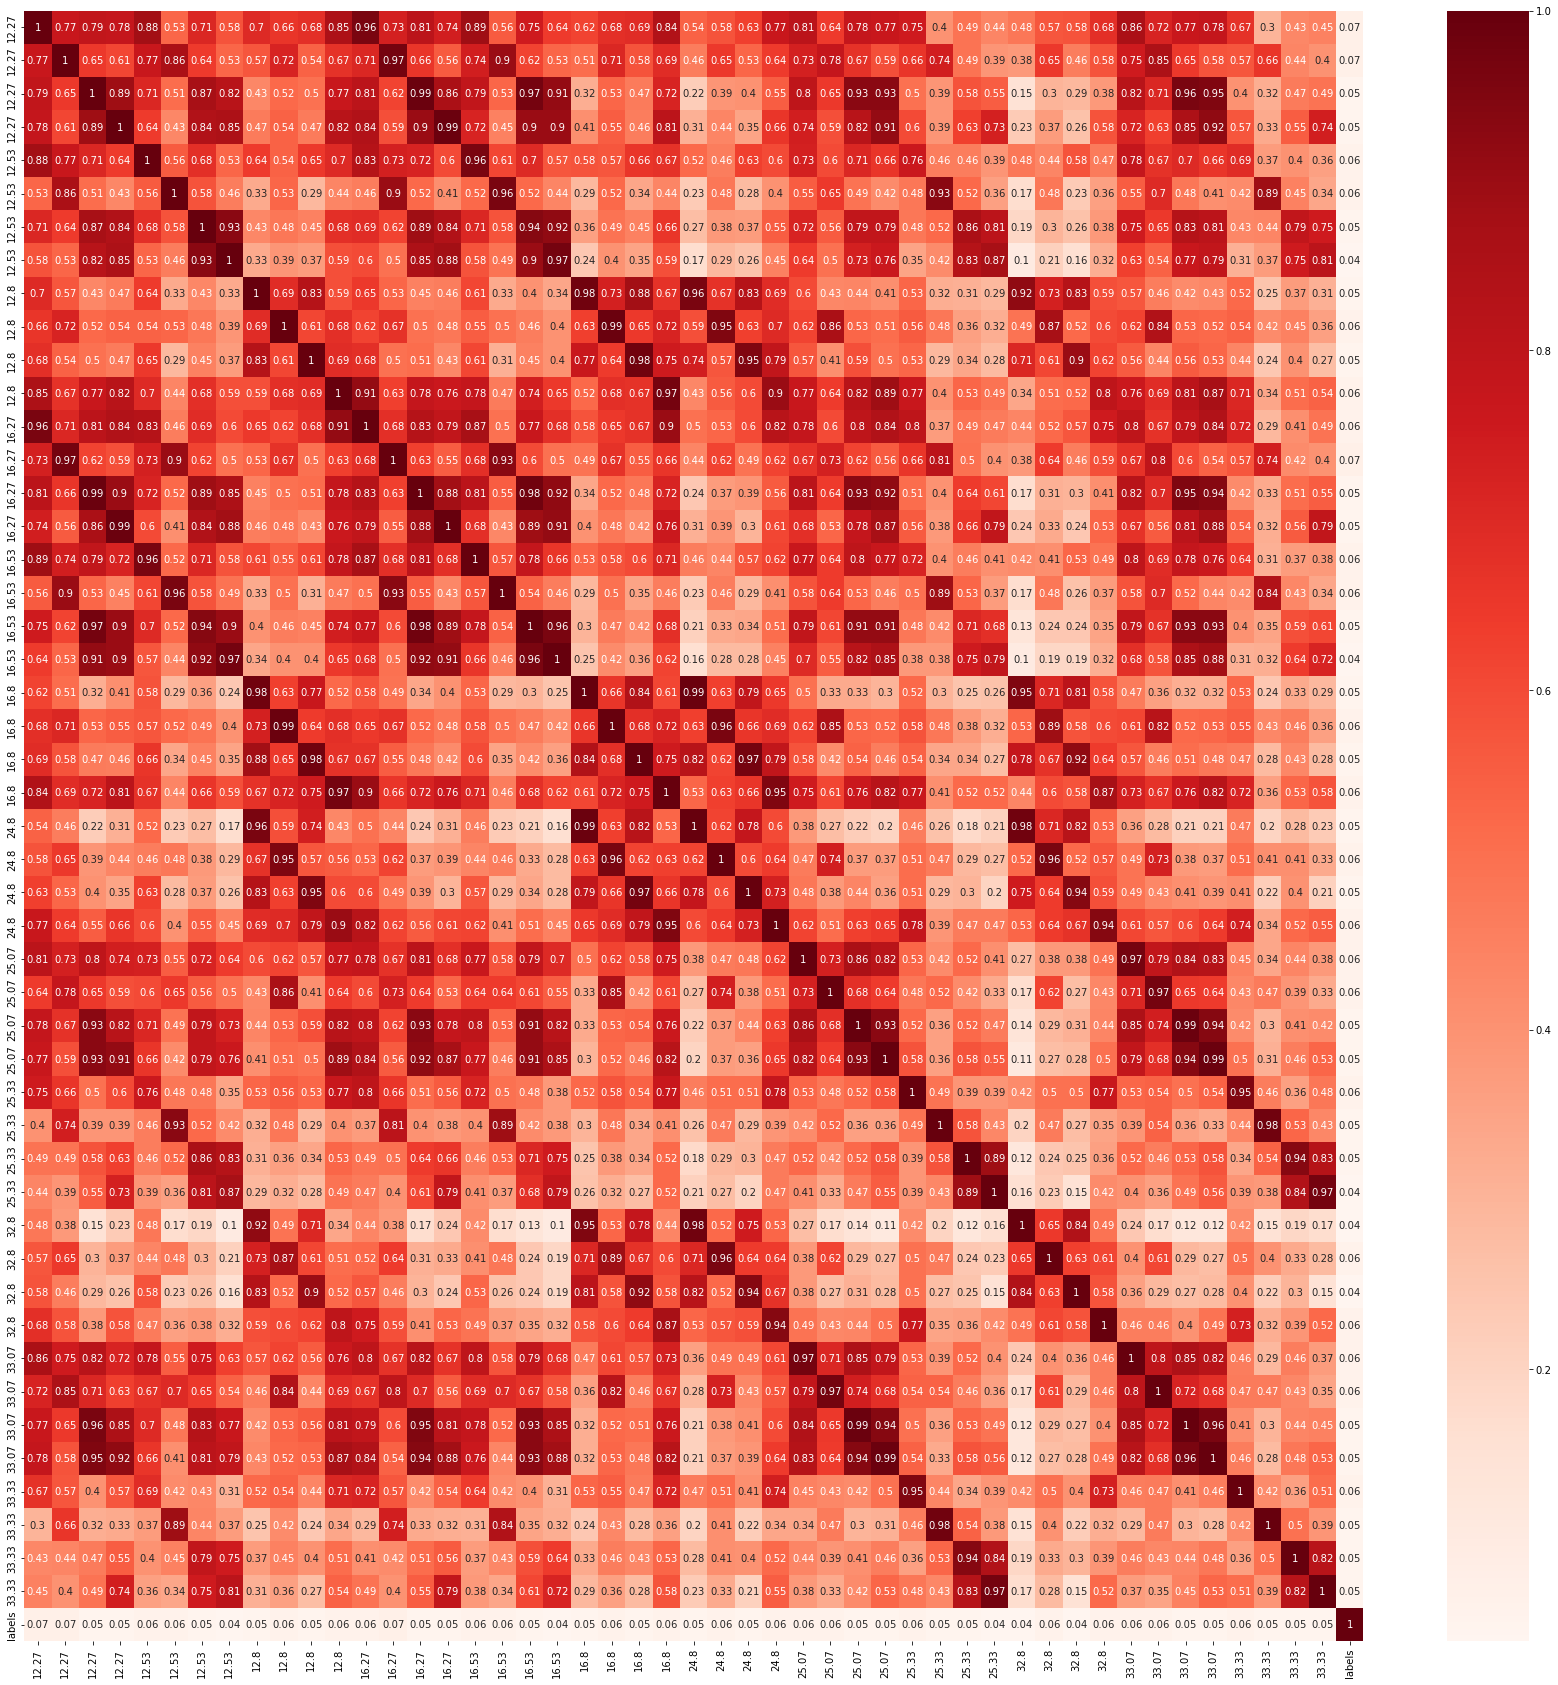

In [92]:
# freq_range_with_labels - Parte 2
corr_table = freq_range_with_labels[['12.27','12.53','12.8','16.27', '16.53', '16.8'
                                               ,'24.8', '25.07', '25.33','32.8','33.07', '33.33', 'labels'
                                ]].corr().round(2)
plt.figure(figsize = (30, 30))
sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds)

## Aprendizaje Supervisado

**A) Benchmarking y desarrollo del algoritmo evaluador:**
       
**a)** Utilice una clasificación aleatoria de los ejemplos para utilizar como benchmark de los resultados posteriores. Este benchmark representa el peor de los desempeños de clasificación posibles.

**b)** Evalúe el desempeño/rendimiento de este benchmark bajo las métricas seleccionadas en el apartado anterior. Considere repetir este procesamiento algunas veces para obtener un promedio, máximo, mínimo u otro representante de estos resultados, ya que se trata de un proceso completamente aleatorizado.

In [93]:
best_features.labels.unique()

array([ 1.,  2., 99.])

**División en los conjuntos de train, test y validation**

In [94]:
X, y = best_features.iloc[:, :-1], best_features.labels

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y) # se queda con el 10% para validación
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train) # del 90% hace 20% para train y 80% para test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Veamos la proporción del target (columna 'labels') en el dataset antes de la división:

In [96]:
len(y)

2005

In [97]:
y.value_counts()

99.0    1000
2.0      524
1.0      481
Name: labels, dtype: int64

Vemos que la proporción de la etiqueta '99' es casi 3 a 1 con respecto a las etiquetas '1' y '2'.

Chequeamos el desbalanceo en los conjuntos de train, test y val:

In [98]:
len(y_train)/len(y)*100

71.97007481296758

In [99]:
y_train.value_counts()

99.0    720
2.0     377
1.0     346
Name: labels, dtype: int64

In [100]:
len(y_val)/len(y)*100

10.02493765586035

In [101]:
y_val.value_counts()

99.0    100
2.0      53
1.0      48
Name: labels, dtype: int64

In [102]:
len(y_test)/len(y)*100

18.00498753117207

In [103]:
y_test.value_counts()

99.0    180
2.0      94
1.0      87
Name: labels, dtype: int64

Vemos que la proporción de la etiqueta '99' se mantiene casi 3 a 1 con respecto a las etiquetas '1' y '2', tanto en train, test y val.

### Scaling data

In [104]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

### Ancillary functions

In [105]:
def experiment(model, params, X_train, X_val, X_test):
    model_clf = model(**params)
    model_clf.fit(X_train, y_train)
    y_train_pred=model_clf.predict(X_train)
    y_val_pred = model_clf.predict(X_val)
    y_test_pred = model_clf.predict(X_test)
    clf_report_train = classification_report(y_train, y_train_pred)
    clf_report_val = classification_report(y_val, y_val_pred)
    clf_report_test = classification_report(y_test, y_test_pred)
    return model_clf, clf_report_train, clf_report_val, clf_report_test

def experiment2(model_clf, X_train, X_val, X_test):
    model_clf.fit(X_train, y_train)
    y_train_pred=model_clf.predict(X_train)
    y_val_pred = model_clf.predict(X_val)
    y_test_pred = model_clf.predict(X_test)
    clf_report_train = classification_report(y_train, y_train_pred)
    clf_report_val = classification_report(y_val, y_val_pred)
    clf_report_test = classification_report(y_test, y_test_pred)
    return model_clf, clf_report_train, clf_report_val, clf_report_test


def experiment3(model_clf, X_train, X_val, X_test, fit_params):
    model_clf.fit(X_train, y_train, **fit_params)
    y_train_pred=model_clf.predict(X_train)
    y_val_pred = model_clf.predict(X_val)
    y_test_pred = model_clf.predict(X_test)
    clf_report_train = classification_report(y_train, y_train_pred)
    clf_report_val = classification_report(y_val, y_val_pred)
    clf_report_test = classification_report(y_test, y_test_pred)
    return model_clf, clf_report_train, clf_report_val, clf_report_test

def print_clf_reports(model, clf_report_train, clf_report_val, clf_report_test):
    set_dict = {
        'Train': clf_report_train, 
        'Val': clf_report_val, 
        'Test': clf_report_test
    }
    
    for key in set_dict:
        print("================================================================================")
        print("Model: ", str(model), " - " , key, " Clasification Report")
        print("================================================================================")
        print(set_dict[key])


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
    

### Baseline model: Dumy Classifier

Como se espera de una estrategia uniforme, la distribución del target es aleatoria y no refleja la verdadera distribución de las etiquetas.

Para tener en cuenta el inconveniente mencionado anteriormente, podemos utilizar la estrategia "estratificada". Las predicciones se generan aleatoriamente, pero se mantiene la distribución de las clases del conjunto de entrenamiento. Al igual que en la estrategia estratificada train_test_split.

In [106]:
from sklearn.dummy import DummyClassifier

params = {
    'strategy':'stratified'
}

model = DummyClassifier
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment(model, params, X_train, X_val, X_test)
print_clf_reports(model_clf, clf_report_train, clf_report_val, clf_report_test)

Model:  DummyClassifier(strategy='stratified')  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       0.22      0.21      0.21       346
         2.0       0.25      0.25      0.25       377
        99.0       0.48      0.50      0.49       720

    accuracy                           0.36      1443
   macro avg       0.32      0.32      0.32      1443
weighted avg       0.36      0.36      0.36      1443

Model:  DummyClassifier(strategy='stratified')  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.13      0.15      0.14        48
         2.0       0.24      0.21      0.22        53
        99.0       0.45      0.46      0.46       100

    accuracy                           0.32       201
   macro avg       0.27      0.27      0.27       201
weighted avg       0.32      0.32      0.32       201

Model:  DummyClassifier(strategy='stratified')  -  Test  Clasification Report
    

**Métricas:**

- 'F1 Score' de cada clase.
- y el 'F1 Macro Score average'.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

- 'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

- 'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

- 'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

- 'samples':
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Los micro y macro promedios (para cualquier métrica) calcularán cosas ligeramente diferentes y, por lo tanto, su interpretación difiere. Un macro-promedio calculará la métrica independientemente para cada clase y luego tomará el promedio (por lo tanto, tratará a todas las clases por igual), mientras que un micro-promedio agregará las contribuciones de todas las clases para calcular la métrica promedio. En una configuración de clasificación de varias clases, es preferible el micro-promedio si sospecha que puede haber un desequilibrio de clase (es decir, puede tener muchos más ejemplos de una clase que de otras clases).

Ver:

https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

**Comparemos las métricas obtenidas por un modelo baseline "Dummy Clasiffier", y otros modelos con sus parámetros por defecto.**

In [107]:
### PROBAMOS el f1_score en vez de  cross_val_score

print('==========================================')
print('Baselines Models')
print('==========================================')

models = []
names = []

random_state = 42

models.append(('Dummy Classifier', DummyClassifier(strategy='stratified')))#, random_state=random_state)))
models.append(('Decission Tree', DecisionTreeClassifier()))#random_state=random_state)))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))#, random_state=random_state)))
models.append(('LightGBM', LGBMClassifier()))#random_state=random_state))) 
models.append(('Support Vector', SVC()))#random_state=random_state)))
models.append(('KNeighbors', KNeighborsClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))#random_state=random_state)))
models.append(('Random Forest', RandomForestClassifier()))#random_state=random_state)))

results_all = {
    'transformer0_train': [],
    'transformer0_val': [],
    'transformer0_test': [],
}

for name, model in models:

    results = {
        'transformer0_train': [],
        'transformer0_val': [],
        'transformer0_test': [],
    }
    
            
    print('')
    print(f'{name}')
    print('========================================== \n')
    
    # 5 iterations of each model
    for i in range(5):
        
        #cv_results_t0_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
        #cv_results_t0_val = cross_val_score(model, X_val, y_val, cv=cv, scoring='f1_macro')
        #cv_results_t0_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='f1_macro')

        model_clf, clf_report_train, clf_report_val, clf_report_test = experiment2(model, X_train, X_val, X_test)
        #print_clf_reports(model_clf, clf_report_train, clf_report_val, clf_report_test)
        
        y_train_pred=model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        cv_results_t0_train = f1_score(y_train, y_train_pred, average='macro')
        cv_results_t0_val = f1_score(y_val, y_val_pred, average='macro')
        cv_results_t0_test = f1_score(y_test, y_test_pred, average='macro')      
         
        
        results['transformer0_train'].append(cv_results_t0_train)
        results['transformer0_val'].append(cv_results_t0_val)
        results['transformer0_test'].append(cv_results_t0_test)
        
    print_clf_reports(model_clf, clf_report_train, clf_report_val, clf_report_test)    
    results_all['transformer0_train'].append(results['transformer0_train'])
    results_all['transformer0_val'].append(results['transformer0_val'])
    results_all['transformer0_test'].append(results['transformer0_test'])
        
    print("Train F1 Score Macro:")
    print(list(map(lambda x: round(x, ndigits=3), results['transformer0_train'])), "\n")
    
    print("Val F1 Score Macro:")
    print(list(map(lambda x: round(x, ndigits=3), results['transformer0_val'])), "\n")
        
    print("Test F1 Score Macro:")
    print(list(map(lambda x: round(x, ndigits=3), results['transformer0_test'])), "\n")

    names.append(name)

    print('Train - F1 Score Macro mean: %.3f - ' % cv_results_t0_train.mean(), \
          'F1 Score Macro min: %.3f - ' % cv_results_t0_train.min(), \
          'F1 Score Macro max: %.3f' % cv_results_t0_train.max())
    
    print('Val - F1 Score Macro mean: %.3f - ' % cv_results_t0_val.mean(), \
          'F1 Score Macro min: %.3f - ' % cv_results_t0_val.min(), \
          'F1 Score Macro max: %.3f' % cv_results_t0_val.max())
    
    print('Test - F1 Score Macro mean: %.3f - ' % cv_results_t0_test.mean(), \
          'F1 Score Macro min: %.3f - ' % cv_results_t0_test.min(), \
          'F1 Score Macro max: %.3f' % cv_results_t0_test.max())
    
#print(results)

Baselines Models

Dummy Classifier

Model:  DummyClassifier(strategy='stratified')  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       0.26      0.26      0.26       346
         2.0       0.26      0.26      0.26       377
        99.0       0.51      0.51      0.51       720

    accuracy                           0.38      1443
   macro avg       0.34      0.34      0.34      1443
weighted avg       0.38      0.38      0.38      1443

Model:  DummyClassifier(strategy='stratified')  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.22      0.23      0.23        48
         2.0       0.29      0.30      0.30        53
        99.0       0.53      0.51      0.52       100

    accuracy                           0.39       201
   macro avg       0.35      0.35      0.35       201
weighted avg       0.39      0.39      0.39       201

Model:  DummyClassifier(strategy='stratified')

Model:  LGBMClassifier()  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Model:  LGBMClassifier()  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.88      0.90      0.89        48
         2.0       0.81      0.66      0.73        53
        99.0       0.79      0.86      0.82       100

    accuracy                           0.82       201
   macro avg       0.83      0.81      0.81       201
weighted avg       0.82      0.82      0.81       201

Model:  LGBMClassifier()  -  Test  Clasification Report
              precision    recall  f1-score   support

         1.0   

Model:  RandomForestClassifier()  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Model:  RandomForestClassifier()  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.88      0.79      0.84        48
         2.0       0.86      0.58      0.70        53
        99.0       0.75      0.91      0.82       100

    accuracy                           0.80       201
   macro avg       0.83      0.76      0.78       201
weighted avg       0.81      0.80      0.79       201

Model:  RandomForestClassifier()  -  Test  Clasification Report
              precision    recall  f1-score   

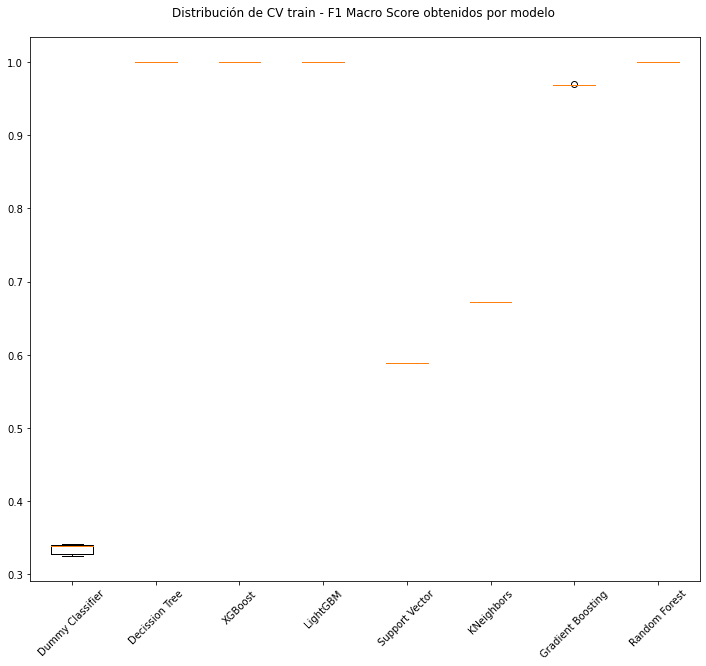

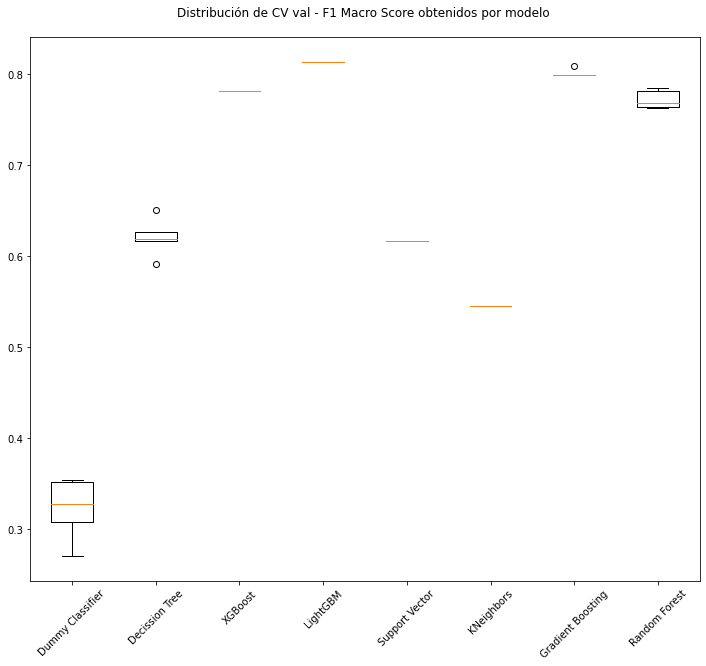

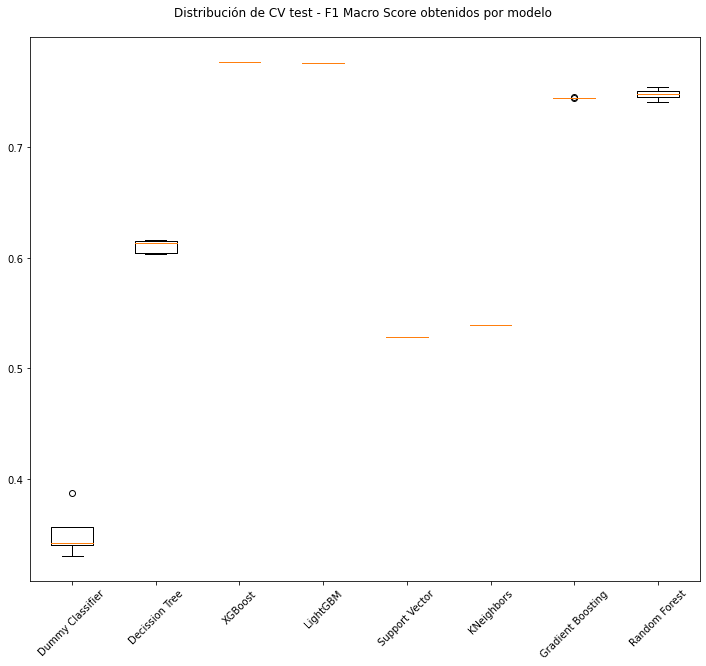

In [108]:
results_set = ['train', 'val', 'test']
for i in results_set:
    #print(results_all[f'transformer0_{i}'])
    plt.figure(figsize=(12, 10))
    plt.boxplot(results_all[f'transformer0_{i}'], labels=names)
    plt.title(f"Distribución de CV {i} - F1 Macro Score obtenidos por modelo \n")
    plt.xticks(rotation=45)
    #plt.ylim(0.2, 1)
    plt.show() 
print('')

# Se ven así porque entre las distintas ejecuciones tienen poca o ninguna variación los resultados
# Pero siguen siendo mejores los 4 modelos ya elegidos.

In [109]:
# Training Learning Curve
# Interpretation: 
# https://towardsdatascience.com/plotting-the-learning-curve-with-a-single-line-of-code-90a5bbb0f48a
#for name, model in models:
#    title = name
#    estimator=model
    
#    plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.5, 1.01),
#                    cv=cv, n_jobs=4)

### B) Búsqueda a grandes rasgos:

**a)** Utilicen la mayor cantidad de algoritmos de aprendizaje automático supervisado que puedan (mínimo 3). Creen para cada uno un modelo bajo el paradigma de dicho método y entrénelo con el dataset elegido. Opcional:
generar curvas de progreso de métricas y funciones de pérdida a lo largo del entrenamiento.

**b)** No hace falta que la búsqueda de hiperparámetros extremadamente detallada, ya que esto se llevará a cabo en el inciso C), sino más bien una exploración general de las tendencias de cada modelo.

**c)** Si encuentra resultados de las métricas analizadas o gráficos de entrenamiento ploteados que resulten destacables -no sólo porque sean valores más óptimos, sino también posibles casos extraños, situaciones de
over y underfitting, etc- muéstrelos y analícelos en este inciso.

In [110]:
# Probar para los 4 mejores modelos correrlos con otros parámetros y plotear sus loss plots
# XGBoost: 'mlogloss plot' y 'merror plot'

¿Qué significa conceptualmente la pérdida logarítmica (logloss)?

La pérdida logarítmica indica lo cerca que está la probabilidad de predicción del valor real/verdadero correspondiente (1, 2, 99, en éste caso de clasificación multiclase). Cuanto más se aleje la probabilidad predicha del valor real, mayor será el valor de la pérdida logarítmica.

**Entrenaremos los modelos baselines que mejores resultados han dado cambiando los parámetros por defecto:**

- XGBoost
- LGBM
- RandomForest
- Gradient Boosting

#### XGBoost

In [111]:
params = {
    'alpha': 0.1,
    'colsample_bytree': 0.5,
    'gamma': 0.2,
    'learning_rate': 0.2,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1.0
}

eval_set = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
eval_metric = ["merror","mlogloss"]
fit_params = {
    'eval_set': eval_set, 
    'eval_metric' : eval_metric, 
    'verbose': False
}

model_clf = XGBClassifier(**params, random_state=random_state)
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment3(model_clf, X_train, X_val, X_test, fit_params)

#model_clf.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)
results = model_clf.evals_result()
# validation_0 (Train) 
# validation_1 (Val)
# validation_2 (Test)

print_clf_reports("XGBClassifier", clf_report_train, clf_report_val, clf_report_test)

Model:  XGBClassifier  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       346
         2.0       0.99      0.98      0.98       377
        99.0       0.99      0.99      0.99       720

    accuracy                           0.99      1443
   macro avg       0.99      0.99      0.99      1443
weighted avg       0.99      0.99      0.99      1443

Model:  XGBClassifier  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.87      0.85      0.86        48
         2.0       0.81      0.66      0.73        53
        99.0       0.77      0.86      0.82       100

    accuracy                           0.81       201
   macro avg       0.82      0.79      0.80       201
weighted avg       0.81      0.81      0.80       201

Model:  XGBClassifier  -  Test  Clasification Report
              precision    recall  f1-score   support

         1.0       0.82 

**Matrices de confusión**

Text(0.5, 1.0, 'XGBoost - Test Confusion matrix')

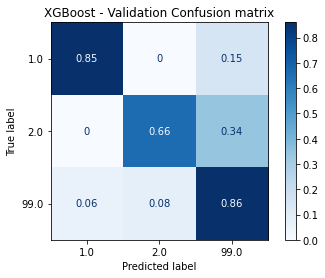

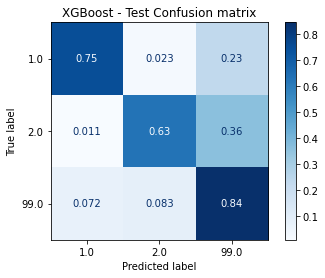

In [112]:
# Val
plot_confusion_matrix(estimator=model_clf, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues')
plt.title('XGBoost - Validation Confusion matrix')

# Test
plot_confusion_matrix(estimator=model_clf, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues')
plt.title('XGBoost - Test Confusion matrix')

**Funciones de pérdida**

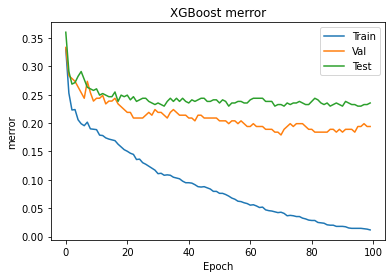

In [124]:
# XGBoost MERROR

epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.plot(x_axis, results['validation_2']['merror'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('merror')
plt.title('XGBoost merror')
plt.show()

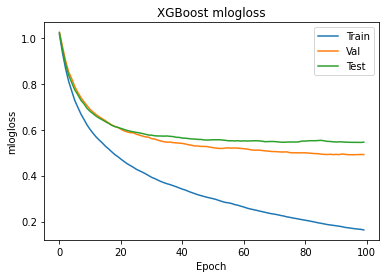

In [125]:
# XGBoost MLOGLOSS

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.plot(x_axis, results['validation_2']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

**[TODO]** Ver cómo se interpretan las curvas de 'merror' y 'mlogloss'.

Ver: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

#### LGBM

In [115]:
import lightgbm as lgb

params = {
    'is_unbalance': True,
    'learning_rate': 0.01,
    'objective': 'multiclass'
}

eval_set = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
eval_names = ['Train', 'Val', 'Test']
eval_metric = ["multi_logloss"] # Only one metric supported because different metrics have various scales.
fit_params = {
    'eval_set': eval_set, 
    'eval_metric' : eval_metric,
    'eval_names': eval_names,
    'verbose': False
}

model_clf = LGBMClassifier(**params, random_state=random_state)
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment3(model_clf, X_train, X_val, X_test, fit_params)

#model_clf.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)
#results = model_clf.evals_result()
# validation_0 (Train) 
# validation_1 (Val)
# validation_2 (Test)

print_clf_reports("LGBMClassifier", clf_report_train, clf_report_val, clf_report_test)

Model:  LGBMClassifier  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       0.96      0.88      0.92       346
         2.0       0.98      0.85      0.91       377
        99.0       0.88      0.97      0.92       720

    accuracy                           0.92      1443
   macro avg       0.94      0.90      0.92      1443
weighted avg       0.92      0.92      0.92      1443

Model:  LGBMClassifier  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.90      0.79      0.84        48
         2.0       0.82      0.60      0.70        53
        99.0       0.74      0.89      0.81       100

    accuracy                           0.79       201
   macro avg       0.82      0.76      0.78       201
weighted avg       0.80      0.79      0.79       201

Model:  LGBMClassifier  -  Test  Clasification Report
              precision    recall  f1-score   support

         1.0       0.

**Matrices de confusión**

Text(0.5, 1.0, 'LGBM - Test Confusion matrix')

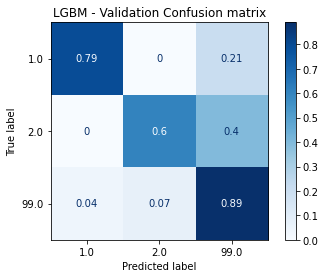

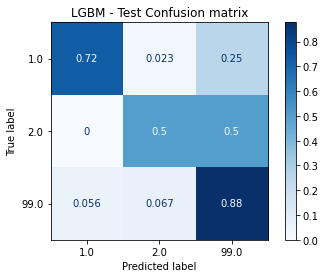

In [116]:
# Val
plot_confusion_matrix(estimator=model_clf, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues')
plt.title('LGBM - Validation Confusion matrix')

# Test
plot_confusion_matrix(estimator=model_clf, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues')
plt.title('LGBM - Test Confusion matrix')

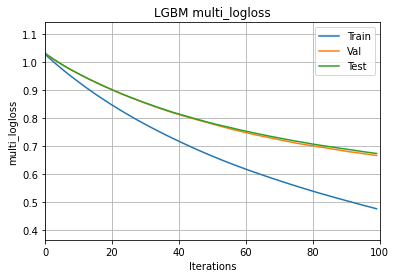

In [117]:
lgb.plot_metric(model_clf) 
# Only one metric supported because different metrics have various scales.
plt.title('LGBM multi_logloss')
plt.show()

#### Gradient Boosting

Para las funciones de pérdida ver: https://scikit-learn.org/stable/modules/ensemble.html#loss-functions

In [118]:
params = {
    'n_estimators': 100,
    'learning_rate': 0.5,
    'max_features' : 'sqrt'  
}



model_clf = GradientBoostingClassifier(**params, random_state=random_state)
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment2(model_clf, X_train, X_val, X_test)



print_clf_reports("GradientBoostingClassifier", clf_report_train, clf_report_val, clf_report_test)

Model:  GradientBoostingClassifier  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Model:  GradientBoostingClassifier  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.82      0.83      0.82        48
         2.0       0.78      0.60      0.68        53
        99.0       0.76      0.84      0.80       100

    accuracy                           0.78       201
   macro avg       0.78      0.76      0.77       201
weighted avg       0.78      0.78      0.77       201

Model:  GradientBoostingClassifier  -  Test  Clasification Report
              precision    recall  f1-sc

**Matrices de confusión**

Text(0.5, 1.0, 'Gradient Boosting - Test Confusion matrix')

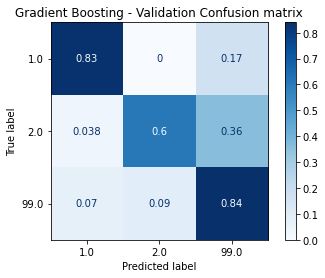

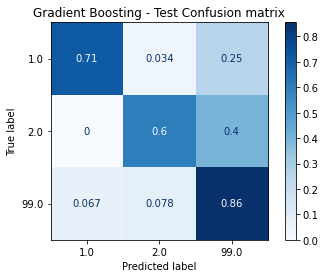

In [119]:
# Val
plot_confusion_matrix(estimator=model_clf, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues')
plt.title('Gradient Boosting - Validation Confusion matrix')

# Test
plot_confusion_matrix(estimator=model_clf, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues')
plt.title('Gradient Boosting - Test Confusion matrix')

#### Random Forest

In [120]:
params = {
    'n_estimators': 300,
    'max_depth'   : 15,
    'criterion'   : 'gini',
    'max_features': 0.25,
    'min_samples_split': 4
}


model_clf = RandomForestClassifier(**params, random_state=random_state)
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment2(model_clf, X_train, X_val, X_test)

print_clf_reports("RandomForestClassifier", clf_report_train, clf_report_val, clf_report_test)

Model:  RandomForestClassifier  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Model:  RandomForestClassifier  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.86      0.75      0.80        48
         2.0       0.84      0.58      0.69        53
        99.0       0.74      0.90      0.81       100

    accuracy                           0.78       201
   macro avg       0.81      0.74      0.77       201
weighted avg       0.79      0.78      0.78       201

Model:  RandomForestClassifier  -  Test  Clasification Report
              precision    recall  f1-score   suppor

**Matrices de confusión**

Text(0.5, 1.0, 'Random Forest - Test Confusion matrix')

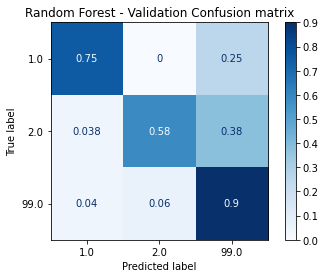

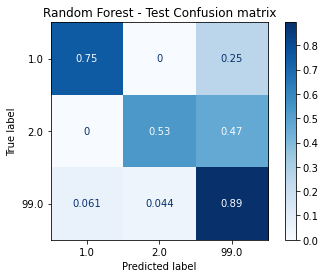

In [121]:
# Val
plot_confusion_matrix(estimator=model_clf, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues')
plt.title('Random Forest - Validation Confusion matrix')

# Test
plot_confusion_matrix(estimator=model_clf, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues')
plt.title('Random Forest - Test Confusion matrix')

### C) Búsqueda puntualizada:

**a)** Con el modelo que presente mejores resultados, lleve a cabo una búsqueda ahora sí más detallista, variando los hiperparámetros y funciones de costo. Si estos métodos permiten variar la cantidad de instancias/épocas de
entrenamiento, analice lo que sucede cuando varía las duraciones de entrenamiento.

**b)** Reporte los resultados obtenidos y seleccione el set completo de configuraciones que mejor resuelven, bajo su criterio, nuestro problema de clasificación.

**Random Forest con búsqueda de Hiperparámetros y CV**

In [49]:
cv = 3

In [50]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100,150,200],
    'max_features': [5, 9,'log2','auto'],
    'max_depth'   : [None, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Grid Search CV implementation
rf = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state=random_state)
rf_clf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=3)

rf_clf.fit(X_train, y_train)
rf_clf.best_params_

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 9,
 'n_estimators': 200}

In [51]:
print("====================================================================")
print("Random Forest Classifier con CV - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, rf_clf.predict(X_train)))

print("====================================================================")
print("Random Forest Classifier con CV - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, rf_clf.predict(X_val)))

print("====================================================================")
print("Random Forest Classifier con CV - Reporte de clasificación de test")
print("====================================================================")
print(classification_report(y_test, rf_clf.predict(X_test)))

Random Forest Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Random Forest Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

         1.0       0.89      0.81      0.85        48
         2.0       0.79      0.58      0.67        53
        99.0       0.75      0.88      0.81       100

    accuracy                           0.79       201
   macro avg       0.81      0.76      0.78       201
weighted avg       0.79      0.79      0.78       201

Random Forest Classifier con CV - Reporte de clasificación de test
              precision    recall  f1

**Gradient Boosting con búsqueda de Hiperparámetros y CV**

In [52]:
param_grid = {
    'n_estimators': [50,100,150],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
}

gb = GradientBoostingClassifier(random_state=random_state)
gb_clf = GridSearchCV(gb, param_grid, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=3)

gb_clf.fit(X_train, y_train)
gb_clf.best_params_

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 100}

In [53]:
print("=======================================================================")
print("Gradient Boosting Classifier con CV - Reporte de clasificación de train")
print("=======================================================================")
print(classification_report(y_train, gb_clf.predict(X_train)))

print("=====================================================================")
print("Gradient Boosting Classifier con CV - Reporte de clasificación de val")
print("=====================================================================")
print(classification_report(y_val, gb_clf.predict(X_val)))

print("======================================================================")
print("Gradient Boosting Classifier con CV - Reporte de clasificación de test")
print("======================================================================")
print(classification_report(y_test, gb_clf.predict(X_test)))

Gradient Boosting Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       346
         2.0       0.98      0.93      0.95       377
        99.0       0.96      0.98      0.97       720

    accuracy                           0.97      1443
   macro avg       0.97      0.97      0.97      1443
weighted avg       0.97      0.97      0.97      1443

Gradient Boosting Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

         1.0       0.91      0.83      0.87        48
         2.0       0.78      0.66      0.71        53
        99.0       0.77      0.86      0.81       100

    accuracy                           0.80       201
   macro avg       0.82      0.78      0.80       201
weighted avg       0.80      0.80      0.80       201

Gradient Boosting Classifier con CV - Reporte de clasificación de test
              precision  

**XGBoost con búsqueda de Hiperparámetros y CV**

In [54]:
# DA ERROR SI NO REEMPLAZO EL 99, EN LAS MÉTRICAS EL 0 SE CORRESPONDE CON LA ETIQUETA 99.
y_train2 = y_train.astype('int').replace(99, 0)
print(y_train2.unique())

y_val2 = y_val.astype('int').replace(99, 0)
print(y_val2.unique())

y_test2 = y_test.astype('int').replace(99, 0)
print(y_test2.unique())

[0 1 2]
[0 2 1]
[1 0 2]


In [55]:
y_train2.dtype

dtype('int64')

**Parámetros**

https://xgboost.readthedocs.io/en/latest/parameter.html

- **'learning_rate'**: La reducción del tamaño del paso se utiliza en la actualización para evitar el overfitting. Después de cada paso de boosting, podemos obtener directamente los pesos de los nuevos features, y 'learning_rate' encoge los pesos de los features para que el proceso de boosting sea más conservador. Rango: [0,1]
- **'max_depth'**: Profundidad máxima de un árbol. Aumentar este valor hará que el modelo sea más complejo y más probable que se sobreajuste. 0 sólo se acepta en la política de crecimiento de 'lossguide' cuando 'tree_method' se establece como 'hist' o 'gpu_hist' e indica que no hay límite en la profundidad. Tenga en cuenta que XGBoost consume agresivamente la memoria cuando entrena un árbol profundo. Rango: [0,∞]

In [56]:
param_grid = {
    "learning_rate": [0.1, 0.2, 0.3] ,
    "max_depth": [ 3, 6, 10],
    'subsample': [0.6, 0.8, 1],
    'eval_metric': ['merror', 'mlogloss']
}

xgb = XGBClassifier(use_label_encoder=False, objective = 'multi:softprob', num_class=2, random_state=random_state)
xgb_clf = GridSearchCV(xgb, param_grid, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=3)
xgb_clf.fit(X_train, y_train2)
xgb_clf.best_params_

<IPython.core.display.Javascript object>

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'eval_metric': 'merror',
 'learning_rate': 0.2,
 'max_depth': 10,
 'subsample': 0.8}

In [57]:
print("====================================================================")
print("XGboost Classifier con CV - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train2, xgb_clf.predict(X_train)))

print("====================================================================")
print("XGboost Classifier con CV - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val2, xgb_clf.predict(X_val)))

print("====================================================================")
print("XGboost Classifier con CV - Reporte de clasificación de test")
print("====================================================================")
print(classification_report(y_test2, xgb_clf.predict(X_test)))

XGboost Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       720
           1       1.00      1.00      1.00       346
           2       1.00      1.00      1.00       377

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

XGboost Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.89      0.85      0.87        48
           2       0.80      0.66      0.72        53

    accuracy                           0.81       201
   macro avg       0.82      0.79      0.80       201
weighted avg       0.81      0.81      0.80       201

XGboost Classifier con CV - Reporte de clasificación de test
              precision    recall  f1-score   support



#### LGBM con búsqueda de Hiperparámetros y CV

**Parámetros**

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

- **'boosting_type'**: With LightGBM you can run different types of Gradient Boosting methods. You have: GBDT, DART, and GOSS which can be specified with the boosting parameter.
- **'n_estimators'**: (int, optional (default=100)) – Number of boosted trees to fit.
- **'max_depth'**: (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.
- **'learning_rate'**: (float, optional (default=0.1)) – Boosting learning rate. 

In [58]:
param_grid = {
    'boosting_type': ['gbdt','dart','goss'],
    'n_estimators': [50, 100, 150],
    'max_depth': [-1, 3], #, 5, 10],
    'learning_rate' : [-1, 0.01, 0.1],
}

lgbm = LGBMClassifier(objective='multiclass', metric='multi_logloss', num_class=3, random_state=random_state)
lgbm_clf = RandomizedSearchCV(lgbm, param_grid, n_iter=50, scoring='f1_macro', n_jobs=-1, cv=cv, verbose=3)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 150,
 'max_depth': -1,
 'learning_rate': 0.1,
 'boosting_type': 'dart'}

In [59]:
print("====================================================================")
print("LGBM Classifier con CV - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, lgbm_clf.predict(X_train)))

print("====================================================================")
print("LGBM Classifier con CV - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, lgbm_clf.predict(X_val)))

print("====================================================================")
print("LGBM Classifier con CV - Reporte de clasificación de test")
print("====================================================================")
print(classification_report(y_test, lgbm_clf.predict(X_test)))

LGBM Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       346
         2.0       1.00      1.00      1.00       377
        99.0       1.00      1.00      1.00       720

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

LGBM Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

         1.0       0.85      0.85      0.85        48
         2.0       0.81      0.64      0.72        53
        99.0       0.77      0.86      0.82       100

    accuracy                           0.80       201
   macro avg       0.81      0.79      0.80       201
weighted avg       0.80      0.80      0.80       201

LGBM Classifier con CV - Reporte de clasificación de test
              precision    recall  f1-score   support

         

**CONCLUSIÓN:**

Como resultado de las pruebas de ajuste por hiperparámetros, obtuvimos mejores métricas en el modelo “Light Gradient Boosting Machine (LGBM)”.
Un algoritmo que utilizan la técnica Gradient Boosting para combinar árboles de decisión que individualmente tienen poco poder de predicción pero sumados dan resultados excelentes.

Éste modelo presenta algunas ventajas como:
- una mayor velocidad de entrenamiento y
- una alta eficiencia en el uso de memoria.

Por lo cual éste modelo es un candidato para la resolución del problema con un F1 Score Macro aprox de 0.80.
